In [1]:
#from collections import OrderedDict
#import collections
#from collections import Counter

import os
import pickle
import glob
import gzip
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
os.getcwd()

'/home/admin_user'

In [3]:
filename_mesh = 'mesh_list_2021.pickle'

filename_1 = "merge_limited_df_cutoff_pair.csv" #cutoff
filename_2 = "merge_limited_df.csv"

In [4]:
#MeSH 読込
with open(filename_mesh, 'rb') as f:
    mesh_list = pickle.load(f)

#メッシュから　メッシュIDと疾患/症状メッシュ、TreeNumber を取り出す
#疾患メッシュ：Cのうち C22（動物)とC23.888（症状）を除外したもの）＋F03（精神障害）
#症状メッシュ：C23.888
mesh_diseases = [descriptor for descriptor in tqdm(mesh_list) for uid in descriptor[-1] if ((uid.startswith("C")==True) & (uid.startswith("C22")!=True)&(uid.startswith("C23.888")!=True)) | (uid.startswith("F03")==True) ]
mesh_symptoms = [descriptor for descriptor in tqdm(mesh_list)  for uid in descriptor[-1] if (uid.startswith("C23.888")==True)]
#さらにメッシュ名だけにする＋重複削除
mesh_diseases= pd.DataFrame(mesh_diseases)[1].drop_duplicates(keep='last').reset_index(drop=True).values.tolist()
mesh_symptoms= pd.DataFrame(mesh_symptoms)[1].drop_duplicates(keep='last').reset_index(drop=True).values.tolist()

len(mesh_list),len(mesh_diseases), len(mesh_symptoms)

  0%|          | 0/29917 [00:00<?, ?it/s]

  0%|          | 0/29917 [00:00<?, ?it/s]

(29917, 4887, 394)

In [5]:
os.chdir('/home/admin_user/デスクトップ/pubmed_after_cutoff')
co_occ_pair = pd.read_csv(filename_1)
co_occ_pair =co_occ_pair[['symptom', 'disease', 'co_occurrence']]

In [6]:
#TF-IDF計算

In [7]:
#symptomとペアになるdisease総数
idf_n_i = co_occ_pair.groupby("symptom").count().reset_index()[["symptom", "disease"]].values.tolist()
len(idf_n_i)

384

In [8]:

tfidf_list=[]
N = co_occ_pair["disease"].nunique() #3602 #全疾患の種類数

for pair in tqdm(co_occ_pair.values.tolist()): #co_occ_pair：共起ペアと共起数
    for symptom in idf_n_i: #idf_n_i：symptomとdisease総数
        
        if pair[0]==symptom[0]: #同じsymptomだったら
            
            #バラバシ数式
            W_ij = pair[-1] #diseaseとの共起数
            n_i = symptom[1] #symptomとペアになるdisease総数
            tfidf_value = W_ij*np.log(N /n_i) 
            
            tfidf_list.append([pair[0],  pair[1], W_ij, n_i, tfidf_value])

tfidf = pd.DataFrame(tfidf_list, columns=["symptom","disease","co_occurence", "disease_num", "tf_idf"])
#disease_num：symptomとペアになるdisease総数
tfidf = tfidf.sort_values(by="tf_idf", ascending=False).reset_index(drop=True)


  0%|          | 0/87808 [00:00<?, ?it/s]

In [9]:
a = []
for i  in tfidf["disease"]:
    if "Global" in i:
        a.append(i)
set(a)

{'Amnesia, Transient Global'}

In [10]:
len(tfidf), tfidf["symptom"].nunique(), tfidf["disease"].nunique()

(87808, 384, 4662)

In [11]:
#行列の形にする
pivot_tfidf_df = tfidf.pivot(index='disease', columns='symptom', values='tf_idf').fillna(0)

In [39]:
pivot_tfidf_df

symptom,"Abdomen, Acute",Abdominal Pain,Acute Pain,Aerophagy,Ageusia,"Aging, Premature",Agnosia,Agraphia,"Akathisia, Drug-Induced",Albuminuria,...,Visceral Pain,Vision Disorders,"Vision, Low",Vocal Cord Paralysis,Voice Disorders,Vomiting,"Vomiting, Anticipatory",Waterhouse-Friderichsen Syndrome,Weight Gain,Weight Loss
disease,,,,,,,,,,,,,,,,,,,,,
22q11 Deletion Syndrome,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
"46, XX Disorders of Sex Development",2.045283,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
"ACTH Syndrome, Ectopic",0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
ACTH-Secreting Pituitary Adenoma,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.598134,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
"AIDS Arteritis, Central Nervous System",0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
von Hippel-Lindau Disease,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,22.373870,5.949858,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
"von Willebrand Disease, Type 1",0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
"von Willebrand Disease, Type 2",2.045283,1.482119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.0,1.752638,0.0,0.0,0.0,0.0


In [12]:
pivot_tfidf_df.sum().sum()

4550646.388705483

Text(0, 0.5, 'frequency')

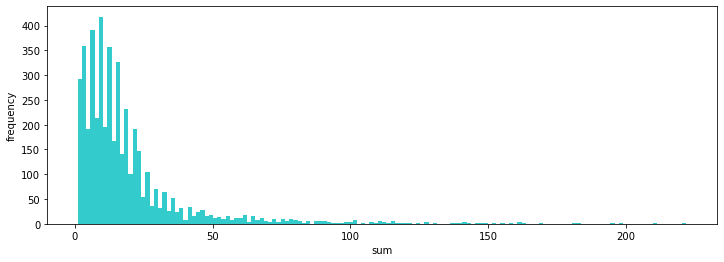

In [13]:
#疾患・症状のTFIDFがゼロより大きい値を取り出した時の可視化

plt.figure(figsize=(12,4))

#TFIDFの数
#plt.subplot(121)
each_disease_sum_vector = [sum(pivot_tfidf_df.loc[disease, :]>0) for disease in pivot_tfidf_df.index]
plt.hist(each_disease_sum_vector,color='c', bins=len(set(each_disease_sum_vector)), alpha=0.8)
plt.xlabel('sum')
plt.ylabel("frequency")


In [14]:
#コサイン類似度　計算

In [15]:
#コサイン算出用データフレームを作る
pre_cosine_df = tfidf.sort_values(['symptom', 'disease'])[['symptom', 'disease',"tf_idf"]].reset_index(drop=True)
pre_cosine_df = pd.pivot_table(pre_cosine_df, index='disease', columns='symptom', values="tf_idf")
pre_cosine_df = pre_cosine_df.fillna(0)#欠損値に0を入れる
#疾患個数
print(len(pre_cosine_df.index))

4662


In [16]:
#疾患ペア(直積ペア)を作る
import itertools
product_list = list(itertools.product(pre_cosine_df.index, pre_cosine_df.index))
print(len(product_list))
product_list[0], product_list[1]

21734244


(('22q11 Deletion Syndrome', '22q11 Deletion Syndrome'),
 ('22q11 Deletion Syndrome', '46, XX Disorders of Sex Development'))

In [17]:
#tfidf行列を疾患（＝行）ごとに分けて直積ペアを作る
vectors = [each_vectors for each_vectors in np.array(pre_cosine_df)]
vectors_list = list(itertools.product(vectors, vectors))

In [18]:
#コサイン類似度

#NonDecimal
#from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

#計算式
def cosine_similarity(x, y):#xとyはベクトルの成分
    return (np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y))))
    #return Decimal(np.dot(x, y) / (np.sqrt(np.dot(x, x)) * np.sqrt(np.dot(y, y)))).quantize(Decimal('0.000001'),rounding=ROUND_HALF_UP)

#直積ペアにコサイン類似度計算を適用 
cosine_similarity_list = []
for disease_pair, vector in tqdm(zip( product_list, vectors_list )):
    cosine_similarity_list.append([disease_pair[0], disease_pair[-1], cosine_similarity(vector[0], vector[1])])

0it [00:00, ?it/s]

In [38]:
pivot_cosine_df

disease_2,22q11 Deletion Syndrome,"46, XX Disorders of Sex Development","ACTH Syndrome, Ectopic",ACTH-Secreting Pituitary Adenoma,"AIDS Arteritis, Central Nervous System",AIDS Dementia Complex,AIDS-Associated Nephropathy,AIDS-Related Complex,AIDS-Related Opportunistic Infections,Abdominal Abscess,...,alpha 1-Antitrypsin Deficiency,alpha-Mannosidosis,alpha-Thalassemia,beta-Mannosidosis,beta-Thalassemia,von Hippel-Lindau Disease,"von Willebrand Disease, Type 1","von Willebrand Disease, Type 2","von Willebrand Disease, Type 3",von Willebrand Diseases
disease_1,,,,,,,,,,,,,,,,,,,,,
22q11 Deletion Syndrome,1.000000,0.000000,0.000000,0.000000,0.0,0.100250,0.0,0.000000,0.000000,0.000000,...,0.000000,0.111635,0.143555,0.422251,0.064720,0.096545,0.000000,0.000000,0.000000,0.000000
"46, XX Disorders of Sex Development",0.000000,1.000000,0.135159,0.000000,0.0,0.038676,0.0,0.000000,0.001333,0.050325,...,0.000000,0.000000,0.000000,0.000000,0.005378,0.005471,0.000000,0.014201,0.000000,0.000000
"ACTH Syndrome, Ectopic",0.000000,0.135159,1.000000,0.000000,0.0,0.085465,0.0,0.000000,0.000000,0.036544,...,0.426354,0.000000,0.000000,0.000000,0.160612,0.041777,0.245817,0.250899,0.236190,0.087319
ACTH-Secreting Pituitary Adenoma,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.022177,0.054142,...,0.000000,0.000000,0.000000,0.000000,0.030338,0.123320,0.000000,0.000000,0.000000,0.014567
"AIDS Arteritis, Central Nervous System",0.000000,0.000000,0.000000,0.000000,1.0,0.054500,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
von Hippel-Lindau Disease,0.096545,0.005471,0.041777,0.123320,0.0,0.000000,0.0,0.000000,0.083477,0.019327,...,0.017371,0.307196,0.000000,0.105127,0.149973,1.000000,0.000000,0.000000,0.000000,0.000000
"von Willebrand Disease, Type 1",0.000000,0.000000,0.245817,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.636481,0.960837,0.308643
"von Willebrand Disease, Type 2",0.000000,0.014201,0.250899,0.000000,0.0,0.000000,0.0,0.000000,0.018416,0.232588,...,0.061255,0.000000,0.000000,0.000000,0.124864,0.000000,0.636481,1.000000,0.662424,0.515627


In [19]:
#データフレーム化
cosine_df = pd.DataFrame(cosine_similarity_list, columns=["disease_1", "disease_2", "cosine_similarity"])
cosine_df = cosine_df.sort_values("cosine_similarity", ascending=False).reset_index(drop=True)

pivot_cosine_df = cosine_df.pivot(index='disease_1', columns='disease_2', values='cosine_similarity')#.fillna(0)

In [20]:
len(cosine_df), len(pivot_cosine_df)

(21734244, 4662)

In [21]:
#インデックスを取得
pivot_index = pivot_cosine_df.index.tolist()

In [22]:
#「同じ疾患同士」「順序が逆になっているだけで同じペアの片方」を削除

#アレイに変換
recent_array = np.array(pivot_cosine_df)

#下三角行列を取得する
#numpy.tril()の引数にnumpy.ndarrayを指定すると、対角線より上の成分をゼロとしたnumpy.ndarrayが返される。
#対角線のコサイン値＝１は不要なので、この対角線箇所も含めてゼロにしたい。
#numpy.tril()の第二引数のkで、境界となる対角線の位置が指定できる（正の値だと上側（右側）、負の値だと下側（左側）に移動する）

recent_array = np.tril(recent_array, k=-1) 

#データフレームにする　対角線含む上の値がゼロになっているか確認
repivot_cosine_df= pd.DataFrame(recent_array, index=pivot_cosine_df.index, columns=pivot_cosine_df.columns)


In [23]:
#下三角行列のうち、コサイン値ゼロ以外の値の位置を取得
recent_array_index_list = [[value_0,
                            value_1] for value_0, value_1 in zip(list(np.where(recent_array>0)[0]),
                                                                 list(np.where(recent_array>0)[1]))]


In [24]:
recent_array_index_list[:3]

[[2, 1], [5, 0], [5, 1]]

In [25]:
len(recent_array_index_list)

6313780

In [26]:
#元の（半分ゼロにする前の）行列で同じ位置を指定し、そのインデックス（疾患ペア）と値（コサイン値）を取得
#疾患a, 疾患b, abのコサイン値
repivot_pair = [ [pivot_index[i[0]],
                  pivot_index[i[1]], 
                  repivot_cosine_df.iloc[i[0], i[1]]] for i in tqdm(recent_array_index_list)]

# 作成されるデータは
#    「同じ疾患同士」「順序が逆になっただけの同じペアのうちの片方」「コサイン値ゼロ」これらを除いたデータ

  0%|          | 0/6313780 [00:00<?, ?it/s]

In [27]:
repivot_pair_df = pd.DataFrame(repivot_pair, columns=["disease_1", "disease_2", "cosine_similarity"])

In [28]:
len(repivot_pair_df)

6313780

In [30]:
print(len(repivot_pair_df[repivot_pair_df["cosine_similarity"]>0.1]))
print(len(repivot_pair_df[repivot_pair_df["cosine_similarity"]>0.2]))
print(len(repivot_pair_df[repivot_pair_df["cosine_similarity"]>0.5]))

cos1 = repivot_pair_df[repivot_pair_df["cosine_similarity"]>0.1]
print(len(cos1))
print(len(set(cos1["disease_1"].values.tolist() + cos1["disease_2"].values.tolist())))
print(cos1["cosine_similarity"].max(), cos1["cosine_similarity"].min())

cos1 = repivot_pair_df[ (repivot_pair_df["cosine_similarity"]>0.1) & (repivot_pair_df["cosine_similarity"]<1)]
print(len(cos1))
print(len(set(cos1["disease_1"].values.tolist() + cos1["disease_2"].values.tolist())))
print(cos1["cosine_similarity"].max(), cos1["cosine_similarity"].min())

1567690
766688
136406
1567690
4658
1.0 0.10000021887943857
1567414
4658
0.9999999999999998 0.10000021887943857


In [31]:
hsdn = repivot_pair_df
#保存
hsdn.to_csv("hsdn.csv", index=False)

In [52]:
# TF-IDFした後で、正のコサイン類似度を持つ疾患-疾患ペアの数は？
print(len(repivot_pair_df))

NameError: name 'repivot_pair_df' is not defined

In [54]:
#2021MeSH
os.chdir('/home/admin_user/デスクトップ/pubmed_after_cutoff')

b_ycut = pd.read_csv("barabasi_hsdn.csv")
b_ncut = pd.read_csv("barabasi_uncutoff_hsdn.csv")

our_ycut= pd.read_csv("hsdn.csv") #repivot_pair_df
our_ncut = pd.read_csv("uncutoff_hsdn.csv") #our_try

df_list = ["b_ycut", "b_ncut", "our_ycut", "our_ncut"]
#数
for i in df_list:
    print(i, len(eval(i)), len(set(eval(i)["disease_1"].values.tolist() + eval(i)["disease_2"].values.tolist())))

b_ycut 4891408 4304
b_ncut 7403646 4304
our_ycut 6313780 4662
our_ncut 9115843 4662


In [51]:
disease_name = ["Diabetes Mellitus, Type 1", "Diabetes Mellitus, Type 2", "Schizophrenia", "Arthritis, Rheumatoid"]
disease_name

['Diabetes Mellitus, Type 1',
 'Diabetes Mellitus, Type 2',
 'Schizophrenia',
 'Arthritis, Rheumatoid']

In [54]:
disease_name = ["Diabetes Mellitus, Type 1", "Diabetes Mellitus, Type 2", "Schizophrenia", "Arthritis, Rheumatoid"]
for i in disease_name[:]:
    print(i)
    val_1 = len(repivot_pair_df[(repivot_pair_df["disease_1"] == i) &(repivot_pair_df["cosine_similarity"] > 0.5) ].sort_values("cosine_similarity",ascending=False))
    val_2 = len(repivot_pair_df[(repivot_pair_df["disease_2"] == i) &(repivot_pair_df["cosine_similarity"] > 0.5) ].sort_values("cosine_similarity",ascending=False))
    print(val_1, val_2)
    print("--------")

Diabetes Mellitus, Type 1
3 25
--------
Diabetes Mellitus, Type 2
25 75
--------
Schizophrenia
19 7
--------
Arthritis, Rheumatoid
10 155
--------


In [340]:
disease_name = ["Diabetes Mellitus, Type 1", "Diabetes Mellitus, Type 2", "Schizophrenia", "Arthritis, Rheumatoid"]
for i in disease_name[:]:
    #print(i)
    val_df = pd.DataFrame()
    val_1 = repivot_pair_df[(repivot_pair_df["disease_1"] == i) &(repivot_pair_df["cosine_similarity"] > 0.1) ].sort_values("cosine_similarity",ascending=False)
    val_2 = repivot_pair_df[(repivot_pair_df["disease_2"] == i) &(repivot_pair_df["cosine_similarity"] > 0.1) ].sort_values("cosine_similarity",ascending=False)
    val_2 = val_2.rename(columns={"disease_1":"disease_2", "disease_2":"disease_1"})
    val_df = pd.concat([val_df, val_1, val_2]).reset_index(drop=True)
    #val_df.to_csv(i+".csv", index=False)    
    #print(i+".csv", len(val_df))
    print(i, "->", len(val_1), len(val_2), len(val_df))

Diabetes Mellitus, Type 1 -> 134 411 545
Diabetes Mellitus, Type 2 -> 175 547 722
Schizophrenia -> 232 43 275
Arthritis, Rheumatoid -> 90 1370 1460


disease_name = ["Diabetes Mellitus, Type 1", "Diabetes Mellitus, Type 2", "Schizophrenia", "Arthritis, Rheumatoid"]
for i in disease_name[:]:
    #print(i)
    val_df = pd.DataFrame()
    val_1 = repivot_pair_df[(repivot_pair_df["disease_1"] == i) &(repivot_pair_df["cosine_similarity"] > 0.5) ].sort_values("cosine_similarity",ascending=False)
    val_2 = repivot_pair_df[(repivot_pair_df["disease_2"] == i) &(repivot_pair_df["cosine_similarity"] > 0.5) ].sort_values("cosine_similarity",ascending=False)
    val_2 = val_2.rename(columns={"disease_1":"disease_2", "disease_2":"disease_1"})
    val_df = pd.concat([val_df, val_1, val_2]).reset_index(drop=True)
    #val_df.to_csv(i+".csv", index=False)    
    #print(i+".csv", len(val_df))
    print(i, "->", len(val_1), len(val_2), len(val_df))

In [349]:
tree_cate = [ [mesh[1], mesh[-1][0]] for mesh in mesh_list for s in mesh[-1] if len(s) == 3 ]
tree_cate[:3]

[['Non-Medical Public and Private Facilities', 'J03'],
 ['Amino Acids, Peptides, and Proteins', 'D12'],
 ['Anesthesia and Analgesia', 'E03']]

In [351]:

disease_name = ["Diabetes Mellitus, Type 1", "Diabetes Mellitus, Type 2", "Schizophrenia", "Arthritis, Rheumatoid"]
for i in disease_name[:]:
    #print(i)
    val_df = pd.DataFrame()
    val_4 = pd.DataFrame()
    val_1 = repivot_pair_df[(repivot_pair_df["disease_1"] == i) &(repivot_pair_df["cosine_similarity"] > 0.1) ].sort_values("cosine_similarity",ascending=False)
    val_2 = repivot_pair_df[(repivot_pair_df["disease_2"] == i) &(repivot_pair_df["cosine_similarity"] > 0.1) ].sort_values("cosine_similarity",ascending=False)
    val_2 = val_2.rename(columns={"disease_1":"disease_2", "disease_2":"disease_1"})
    val_3= pd.concat([val_df, val_1, val_2]).reset_index(drop=True)    
    #print(len(val_3))
    
    #ユニークな疾患名がどのメッシュカテゴリーに含まれるか
    disease_category = []
    for  disease in val_3["disease_2"]:
        for mesh in mesh_list:
            if disease == mesh[1]:
                #print(i)
                #print([m[:3] for m in mesh[-1]])
                disease_category.extend ([[disease, m[:3]] for m in mesh[-1]])
                
    val_4 = pd.merge(val_3, pd.DataFrame(disease_category, columns=["disease_2", "treecode"]), on="disease_2")
    
    val_4["treename"]=0
    for enu, code in enumerate(val_4["treecode"]):
        for cate_num in tree_cate:
            if code == cate_num[0]:
                val_4["treename"][enu] = cate_num[1]
    
    print(i, len(val_3), "=>", len(val_4))

Diabetes Mellitus, Type 1 545 => 1319
Diabetes Mellitus, Type 2 722 => 1705
Schizophrenia 275 => 714
Arthritis, Rheumatoid 1460 => 3187


disease_name = ["Diabetes Mellitus, Type 1", "Diabetes Mellitus, Type 2", "Schizophrenia", "Arthritis, Rheumatoid"]
for i in disease_name[:]:
    val_df = pd.DataFrame()
    val_4 = pd.DataFrame()
    val_1 = repivot_pair_df[(repivot_pair_df["disease_1"] == i) &(repivot_pair_df["cosine_similarity"] > 0.5) ].sort_values("cosine_similarity",ascending=False)
    val_2 = repivot_pair_df[(repivot_pair_df["disease_2"] == i) &(repivot_pair_df["cosine_similarity"] > 0.5) ].sort_values("cosine_similarity",ascending=False)
    val_2 = val_2.rename(columns={"disease_1":"disease_2", "disease_2":"disease_1"})
    val_3= pd.concat([val_df, val_1, val_2]).reset_index(drop=True)    
    print(i, len(val_3),len(val_3[~val_3.duplicated()]))

In [585]:
tree_cate = sorted([ [item, mesh[1]] for mesh in mesh_list for item in mesh[-1] if (len(item) == 3) ] )

disease_name = ["Diabetes Mellitus, Type 1", "Diabetes Mellitus, Type 2", "Schizophrenia", "Arthritis, Rheumatoid"]
for i in disease_name[:]:
    #print(i)
    val_df = pd.DataFrame()
    val_4 = pd.DataFrame()
    val_1 = repivot_pair_df[(repivot_pair_df["disease_1"] == i) &(repivot_pair_df["cosine_similarity"] > 0.1) ].sort_values("cosine_similarity",ascending=False)
    val_2 = repivot_pair_df[(repivot_pair_df["disease_2"] == i) &(repivot_pair_df["cosine_similarity"] > 0.1) ].sort_values("cosine_similarity",ascending=False)
    val_2 = val_2.rename(columns={"disease_1":"disease_2", "disease_2":"disease_1"})
    val_3= pd.concat([val_df, val_1, val_2]).reset_index(drop=True)    
    #print(len(val_3))
    
    #ユニークな疾患名がどのメッシュカテゴリーに含まれるか
    disease_category = []
    for  disease in val_3["disease_2"]:
        for mesh in mesh_list:
            if disease == mesh[1]:
                disease_category.extend ([[disease, m] for m in mesh[-1]])
                
    val_4 = pd.merge(val_3, pd.DataFrame(disease_category, columns=["disease_2", "treecode"]), on="disease_2")
    
    val_4["treename"]=0
    for enu, code in enumerate(val_4["treecode"]):
        val_4["treename"][enu] = code[:3]
    
    val_4.to_csv(i+"_01_all.csv", index=False)
    print(i, len(val_3), "=>", len(val_4))

<ipython-input-585-5a98201f54fd>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_4["treename"][enu] = code[:3]
/home/admin_user/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Diabetes Mellitus, Type 1 545 => 1319


<ipython-input-585-5a98201f54fd>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_4["treename"][enu] = code[:3]
/home/admin_user/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Diabetes Mellitus, Type 2 722 => 1705


<ipython-input-585-5a98201f54fd>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_4["treename"][enu] = code[:3]
/home/admin_user/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Schizophrenia 275 => 714


<ipython-input-585-5a98201f54fd>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_4["treename"][enu] = code[:3]
/home/admin_user/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Arthritis, Rheumatoid 1460 => 3187


In [572]:
os.chdir('/home/admin_user')
import openpyxl

import pandas as pd
#input file name
input_file_name = 'category.xlsx'
#xls book Open (xls, xlsxのどちらでも可能)
input_book = pd.ExcelFile(input_file_name)
#sheet_namesメソッドでExcelブック内の各シートの名前をリストで取得できる
input_sheet_name = input_book.sheet_names
#lenでシートの総数を確認
num_sheet = len(input_sheet_name)
#シートの数とシートの名前のリストの表示
print ("Sheet の数:", num_sheet, input_sheet_name)
input_sheet_df = input_book.parse(input_sheet_name[1])

#読み込んだシート名の確認
print("Sheet name:", input_sheet_name[1])
#読み込んだシートの先頭10行を表示
input_sheet_df.head(10)

Sheet の数: 2 ['Sheet1', 'Sheet2']
Sheet name: Sheet2


,ja,en,treecode
0,胃,Stomach,A03.556.875.875
1,胃,Gastrointestinal Diseases,C06.405
2,肝臓,Liver,A03.620
3,肝臓,Liver Diseases,C06.552
4,筋肉,Muscles,A02.633
5,筋肉,Muscles,A10.690
6,筋肉,Muscular Diseases,C05.651
7,筋肉,Muscular Diseases,C10.668.491
8,骨格,Bone and Bones,A02.835.232
9,骨格,Bone and Bones,A10.165.265


In [593]:


for i in disease_name:
    print(i, len(pd.read_csv(str(i)+"_01_all.csv")), pd.read_csv(str(i)+"_01_all.csv")["disease_2"].nunique())


Diabetes Mellitus, Type 1 1319 545
Diabetes Mellitus, Type 2 1705 722
Schizophrenia 714 275
Arthritis, Rheumatoid 3187 1460


In [640]:
test_df = pd.read_csv("Diabetes Mellitus, Type 1_01_all.csv")[["disease_2", "treecode"]]
test_df[:3]

,disease_2,treecode
0,Albuminuria,C12.777.934.734.269
1,Albuminuria,C13.351.968.934.734.269
2,Albuminuria,C23.888.942.750.269


In [641]:
input_sheet_df[:3]

,ja,en,treecode
0,胃,Stomach,A03.556.875.875
1,胃,Gastrointestinal Diseases,C06.405
2,肝臓,Liver,A03.620


In [655]:
a = sample_df[[0,1]]
print(len(a))
print(len(a[~a.duplicated(keep=False)]))
print(len(a[a.duplicated(keep=False)]))

333
273
60


333


<AxesSubplot:ylabel='None'>

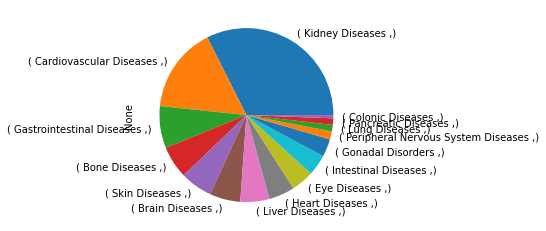

In [671]:
sample_df=pd.DataFrame()
for i in test_df.values.tolist():
    for s in input_sheet_df.values.tolist():
        if s[-1] in i[-1]:
            sample_df = pd.concat([sample_df, pd.DataFrame([i[0],i[-1],s[0],s[1],s[-1]]).T] )
print(len(sample_df))            
sample_df[[3]].to_csv

In [673]:
sample_df.to_excel('Diabetes Mellitus, Type 1_category.xlsx', index=False, header=False)

In [674]:
os.getcwd()

'/home/admin_user'

#cosine>0.1
disease_name = ["Diabetes Mellitus, Type 1", "Diabetes Mellitus, Type 2", "Schizophrenia", "Arthritis, Rheumatoid"]
for i in disease_name:
    pd.read_csv(str(i)+"_01.csv")["treecode"].value_counts().plot.pie()
    print(i)
    plt.show()


#cosine>0.5
disease_name = ["Diabetes Mellitus, Type 1", "Diabetes Mellitus, Type 2", "Schizophrenia", "Arthritis, Rheumatoid"]
for i in disease_name:
    pd.read_csv(str(i)+"_tree.csv")["treecode"].value_counts().plot.pie()
    print(i)
    plt.show()

In [564]:
for i in pd.read_csv("Diabetes Mellitus, Type 2_01.csv")["disease_2"]:
    for mesh in mesh_list:
        if (i==mesh[1]):
            for ms in mesh[-1]:
                if "A" in ms:
                    print(mesh)
                    break;

['D065309', 'Atypical Squamous Cells of the Cervix', ['A11.436.123', 'C04.834.818.249', 'C13.351.500.852.593.074.249', 'C23.149.500']]
['D065309', 'Atypical Squamous Cells of the Cervix', ['A11.436.123', 'C04.834.818.249', 'C13.351.500.852.593.074.249', 'C23.149.500']]
['D065309', 'Atypical Squamous Cells of the Cervix', ['A11.436.123', 'C04.834.818.249', 'C13.351.500.852.593.074.249', 'C23.149.500']]
['D065309', 'Atypical Squamous Cells of the Cervix', ['A11.436.123', 'C04.834.818.249', 'C13.351.500.852.593.074.249', 'C23.149.500']]
['D000072662', 'Margins of Excision', ['A10.830', 'C23.149.625']]
['D000072662', 'Margins of Excision', ['A10.830', 'C23.149.625']]
['D048629', 'Micronuclei, Chromosome-Defective', ['A11.284.430.106.570', 'A11.284.430.214.190.875.117.570', 'C23.550.210.570', 'G05.365.590.175.570']]
['D048629', 'Micronuclei, Chromosome-Defective', ['A11.284.430.106.570', 'A11.284.430.214.190.875.117.570', 'C23.550.210.570', 'G05.365.590.175.570']]
['D048629', 'Micronuclei, 

In [ ]:
words_ja = ["脳","肝臓","胆嚢","腎臓","膵臓","脾臓","心臓","心臓血管","末梢神経","虫垂","大腸","小腸",
            "肺","目","胃","脂肪組織","生殖腺","筋肉","骨格","皮膚"]

In [560]:
words_ja = ["脳","肝臓","胆嚢","腎臓","膵臓","脾臓","心臓","心臓血管","末梢神経","虫垂","大腸","小腸",
            "肺","目","胃","脂肪組織","生殖腺","筋肉","骨格","皮膚"]
words = ["Brain","Liver","Gallbladder","Kidney","Pancreas","Spleen","Heart","Cardiovascular System","Peripheral Nerves","Appendix",
         "Intestine, Large","Intestine, Small","Lung","Eye","Stomach","Adipose Tissue","Gonads","Muscles","Bone and Bones","Skin"]
category_list = []
for enu, (word_ja, word) in enumerate(zip(words_ja, words)):
    for i in mesh_list:       
        if word == i[1]:
            #print(word_ja,"|",i[1],"|",i[-1])
            for item in i[-1]:
                print(word_ja,"|",i[1],"|",item)

脳 | Brain | A08.186.211
肝臓 | Liver | A03.620
胆嚢 | Gallbladder | A03.159.439
腎臓 | Kidney | A05.810.453
膵臓 | Pancreas | A03.734
脾臓 | Spleen | A10.549.700
脾臓 | Spleen | A15.382.520.604.700
心臓 | Heart | A07.541
心臓血管 | Cardiovascular System | A07
末梢神経 | Peripheral Nerves | A08.800.800
虫垂 | Appendix | A03.556.124.526.209.290
虫垂 | Appendix | A03.556.249.249.209.290
大腸 | Intestine, Large | A03.556.124.526
大腸 | Intestine, Large | A03.556.249.249
小腸 | Intestine, Small | A03.556.124.684
肺 | Lung | A04.411
目 | Eye | A01.456.505.420
目 | Eye | A09.371
胃 | Stomach | A03.556.875.875
脂肪組織 | Adipose Tissue | A10.165.114
生殖腺 | Gonads | A05.360.576
生殖腺 | Gonads | A06.300.312
筋肉 | Muscles | A02.633
筋肉 | Muscles | A10.690
骨格 | Bone and Bones | A02.835.232
骨格 | Bone and Bones | A10.165.265
皮膚 | Skin | A17.815


In [561]:
words = ["Brain","Liver","Gallbladder","Kidney","Pancreatic","Splenic","Heart","Cardiovascular","Peripheral Nerv","Append",
         "Colon","Intestinal","Lung","Eye","Gastr","Adipose Tissue","Gonadal","Muscular","Bone","Skin"]

for enu, (word_ja, word) in enumerate(zip(words_ja, words)):
    for i in mesh_df.values.tolist(): 
        if (word+" Diseases" in i[1]) & (i[1].startswith(word)) & (i[1].endswith("Diseases")):
            #print(word_ja,"|",i[1],"|",i[-1])
            for item in i[-1]:
                print(word_ja,"|",i[1],"|",item)


脳 | Brain Diseases | C10.228.140
肝臓 | Liver Diseases | C06.552
胆嚢 | Gallbladder Diseases | C06.130.564
腎臓 | Kidney Diseases | C12.777.419
腎臓 | Kidney Diseases | C13.351.968.419
膵臓 | Pancreatic Diseases | C06.689
脾臓 | Splenic Diseases | C15.604.744
心臓 | Heart Diseases | C14.280
心臓血管 | Cardiovascular Diseases | C14
小腸 | Intestinal Diseases | C06.405.469
肺 | Lung Diseases | C08.381
目 | Eye Diseases | C11
筋肉 | Muscular Diseases | C05.651
筋肉 | Muscular Diseases | C10.668.491
骨格 | Bone Diseases | C05.116
皮膚 | Skin Diseases | C17.800


In [562]:
words = ["Brain","Liver","Gallbladder","Kidney","Pancreatic","Splenic","Heart","Cardiovascular","Peripheral Nerv","Append",
         "Colon","Intestinal","Lung","Eye","Gastr","Adipose Tissue","Gonadal","Muscular","Bone","Skin"]

for enu, (word_ja, word) in enumerate(zip(words_ja, words)):
    for i in mesh_df.values.tolist(): 
        if word+" Diseases" in i[1]:
            print(word_ja,"|",i[1],"|",i[-1])

            
        elif (word in i[1]) & (" Diseases" in i[1]):
            print(word_ja,"|",i[1],"|",i[-1])

        elif (word in i[1]) & (" Disorders" in i[1]):
            print(word_ja,"|",i[1],"|",i[-1])


        elif (word in i[1]) & (" System" in i[1]):
            print(word_ja,"|",i[1],"|",i[-1])



脳 | Brain Diseases | ['C10.228.140']
脳 | Brain Diseases, Metabolic | ['C10.228.140.163', 'C18.452.132']
脳 | Brain Diseases, Metabolic, Inborn | ['C10.228.140.163.100', 'C16.320.565.189', 'C18.452.132.100', 'C18.452.648.189']
肝臓 | Liver Diseases | ['C06.552']
肝臓 | Liver Diseases, Alcoholic | ['C06.552.645', 'C25.775.100.087.645']
肝臓 | Liver Diseases, Parasitic | ['C01.610.518', 'C06.552.664']
胆嚢 | Gallbladder Diseases | ['C06.130.564']
腎臓 | Kidney Diseases | ['C12.777.419', 'C13.351.968.419']
腎臓 | Polycystic Kidney Diseases | ['C12.777.419.403.875', 'C13.351.968.419.403.875', 'C16.131.077.717', 'C16.320.184.625']
腎臓 | Kidney Diseases, Cystic | ['C12.777.419.403', 'C13.351.968.419.403']
腎臓 | National Institute of Diabetes and Digestive and Kidney Diseases (U.S.) | ['I01.409.418.750.600.650.496.450', 'N03.540.052.750.450', 'N03.540.348.500.500.600.650.496.450']
膵臓 | Pancreatic Diseases | ['C06.689']
脾臓 | Splenic Diseases | ['C15.604.744']
心臓 | Heart Conduction System | ['A07.541.409']
心臓 

    Brain ['Brain Diseases', ['C10.228.140']]
    Liver ['Liver Diseases', ['C06.552']]
    Gallbladder ['Gallbladder Diseases', ['C06.130.564']]
    Kidney ['Kidney Diseases', ['C12.777.419', 'C13.351.968.419']]
    Heart ['Heart Diseases', ['C14.280']]
    Cardiovascular ['Cardiovascular Diseases', ['C14']]
    --------------------
4 Pancreas
5 Spleen
8 Peripheral Nerves
9 Appendix


disease_name = ["Diabetes Mellitus, Type 1", "Diabetes Mellitus, Type 2", "Schizophrenia", "Arthritis, Rheumatoid"]
for i in disease_name[:]:
    #print(i)
    val_df = pd.DataFrame()
    val_4 = pd.DataFrame()
    val_1 = repivot_pair_df[(repivot_pair_df["disease_1"] == i) &(repivot_pair_df["cosine_similarity"] > 0.5) ].sort_values("cosine_similarity",ascending=False)
    val_2 = repivot_pair_df[(repivot_pair_df["disease_2"] == i) &(repivot_pair_df["cosine_similarity"] > 0.5) ].sort_values("cosine_similarity",ascending=False)
    val_2 = val_2.rename(columns={"disease_1":"disease_2", "disease_2":"disease_1"})
    val_3= pd.concat([val_df, val_1, val_2]).reset_index(drop=True)    
    print(len(val_3))
    
    #ユニークな疾患名がどのメッシュカテゴリーに含まれるか
    disease_category = []
    for  disease in val_3["disease_2"]:
        for mesh in mesh_list:
            if disease == mesh[1]:
                #print(i)
                #print([m[:3] for m in mesh[-1]])
                disease_category.extend ([[disease, m[:3]] for m in mesh[-1]])
                
    val_4 = pd.merge(val_3, pd.DataFrame(disease_category, columns=["disease_2", "treecode"]), on="disease_2")
    
    val_4["treename"]=0
    for enu, code in enumerate(val_4["treecode"]):
        for cate_num in tree_cate:
            if code == cate_num[0]:
                val_4["treename"][enu] = cate_num[1]
    
    #val_4["category"] = val_4["treecode"]+"_"+val_4["treename"]
    val_4.to_csv(i+"_tree.csv", index=False)
    print(i+"_tree.csv", len(val_4))

                   disease_1    disease_2  cosine_similarity treecode
0  Diabetes Mellitus, Type 1  Albuminuria             0.9404      C12
1  Diabetes Mellitus, Type 1  Albuminuria             0.9404      C13
2  Diabetes Mellitus, Type 1  Albuminuria             0.9404      C23


<AxesSubplot:ylabel='treecode'>

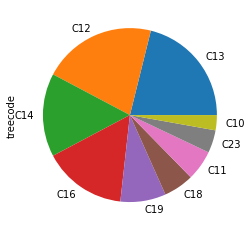

In [199]:
DF = pd.read_csv("Diabetes Mellitus, Type 1_tree.csv")
DF["treecode"].value_counts().plot.pie()

<AxesSubplot:ylabel='treecode'>

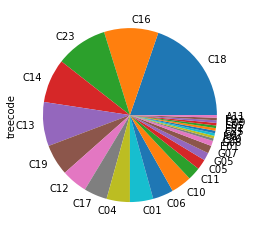

In [296]:
DF = pd.read_csv("Diabetes Mellitus, Type 2_tree.csv")
DF["treecode"].value_counts().plot.pie()

<AxesSubplot:ylabel='treecode'>

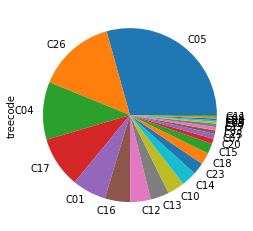

In [295]:
DF = pd.read_csv("Arthritis, Rheumatoid_tree.csv")
DF["treecode"].value_counts().plot.pie()

In [ ]:
#コサイン値1の疾患ペア（同じ疾患同士は除く）から、ユニークな疾患名を抽出

cos1_disease_name = list(set( [i[0] for i in repivot_pair  if i[-1]==1] + [i[1] for i in repivot_pair if i[-1]==1] ))
#3桁のメッシュ＝メッシュカテゴリー　を抽出
tree_cate = [ [mesh[1], mesh[-1][0]] for mesh in mesh_list for s in mesh[-1] if len(s) == 3 ]

#ユニークな疾患名がどのメッシュカテゴリーに含まれるか調査
cos1_disease_category = []
for  i in cos1_disease_name:
    for mesh in mesh_list:
        if i == mesh[1]:
            cos1_disease_category.extend ([m[:3] for m in mesh[-1]])
            
cos1_disease_category_set = []
for i in cos1_disease_category:
    for mesh in tree_cate:
        if i==mesh[-1]:
            cos1_disease_category_set.append(mesh )

print(pd.Series( pd.DataFrame(cos1_disease_category_set)[1] +" "+ pd.DataFrame(cos1_disease_category_set)[0] ).value_counts())
pd.DataFrame(cos1_disease_category_set)[1].value_counts().plot.bar()